# 1 PERKENALAN

= ================================================

Milestone 2<br>
Nama  : Muhammad Jabaris Maulana<br>
Batch : HCK-024<br>
Program ini dibuat untuk membuat prediksi harga sewa apartemen berdasarkan beberapa variabel.

= ================================================

Link Hugging Face https://huggingface.co/spaces/jbrsalan/Apartment_Price_Prediction?logs=container

Conceptual Problems
Jawab pertanyaan berikut:

>Jelaskan latar belakang adanya bagging dan cara kerja bagging!<br>

Bagging adalah salah satu ensamble learning yang memiliki proses melatih model secara independen pada subset berbeda dari dataset yang sama. Hasil prediksi dari masing-masing model yang dilatih akan digabungkan untuk dilakukan voting (klasifikasi) atau averaging (regresi). Hasil dari voting/averaging yang akan diambil sebagai model terbaik. Contoh: RandomForest adalah ensamle learning di mana bagging dilakukan terhadap DecisionTree.

>Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih!<br>

RandomForest bekerja dengan menjalankan sejumlah DecisionTree secara independen di waktu bersamaan (bagging). Sedangkan XGBoost merupakan ensamble learning jenis boosting di mana model ini menjalankan sejumlah DecisionTree secara berurutan dan pohon selanjutnya dibuat berdasarkan data yang sebelumnya sulit diprediksi dengan tujuan mengurangi kesalahan regresi/klasifikasi.

>Jelaskan apa yang dimaksud dengan Cross Validation!<br>

Cross Validation adalah teknik untuk mengevaluasi kinerja model dengan membagi dataset menjadi beberapa bagian (fold). Tujuannya agar model dapat dilatih dengan variasi data berbeda (dari dataset yang sama) sehingga dapat dianggap berlatih berkali-kali untuk mengurangi overfit. Cross validation menghasilkan skor berjumlah sama dengan jumlah fold.

# 2 IMPORT LIBRARIES

In [1]:
# import libraries yang akan digunakan
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr, f_oneway

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import pickle

import warnings
warnings.filterwarnings('ignore') # mematikan warning yang tidak perlu ditampilkan

# 3 DATA LOADING

>Data yang digunakan merupakan data harga sewa apartemen dengan informasi-informasi pendukungnya seperti jumlah kamar, lokasi dan lain-lain. Data didapat dari link berikut:<br>
https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified

Dari data tersebut akan dilakukan pelatihan model untuk melakukan prediksi terhadap harga sewa (target) berdasarkan fitur-fitur yang tersedia.

In [2]:
# muat data menjadi dataframe
raw = pd.read_csv('apartments_for_rent_classified_10K.csv', delimiter=';', encoding='latin1') # menggunakan encoding='latin1' karena terdapat karakter khusus pada data

# tampilkan sample data
raw.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [3]:
# tampilkan info dari data
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 
 17  state          9923 non-null   object 
 18  latitud

>Data memiliki missing value, pada tahap awal ini akan dilakukan penentuan kolom mana saja yang bisa dihapus dan atau dihandle missing value nya berdasarkan analisa awal.

## Hapus Kolom yang Tidak Diperlukan

>Dari semua kolom yang terdapat dalam data, di awal akan ditentukan kolom mana saja yang dirasa tidak diperlukan baik karena tidak memiliki pengaruh terhadap hasil pelatihan model ataupun dapat mempersulit kerja model untuk mempelajari data tersebut.

In [4]:
# cek jumlah masing-masing unique value dari kolom category
raw['category'].value_counts()

category
housing/rent/apartment     9996
housing/rent/home             2
housing/rent/short_term       2
Name: count, dtype: int64

In [5]:
# cek jumlah unique value dari kolom amenities
raw['amenities'].nunique()

2254

In [6]:
# cek jumlah masing-masing unique value dari kolom price_type
raw['price_type'].value_counts()

price_type
Monthly           9998
Weekly               1
Monthly|Weekly       1
Name: count, dtype: int64

In [7]:
# cek unique value dari kolom cityname
raw['cityname'].nunique()

1574

>Dalam data terdapat beberapa kolom yang tidak memiliki relevansi dengan analisis dan pembuatan model sehingga perlu dihapus yaitu:
- `id`: tidak memiliki pengaruh terhadap harga sewa.
- `category`: memiliki 3 unique value dengan hanya 1 unique value yang mendominasi, maka kolom akan dihapus setelah baris berisi unique value lainnya dihapus.
- `title`: tidak memiliki pengaruh terhadap harga sewa.
- `body`: tidak memiliki pengaruh terhadap harga sewa.
- `amenities`: memiliki beberapa nilai di dalam 1 sel sehingga akan membuat model kesulitan mencapai goodfit.
- `currency`: hanya memiliki 1 unique value (USD).
- `fee`: hanya memiliki 1 unique value (No).
- `price_display`: bernilai sama dengan kolom `price`.
- `price_type`: memiliki 3 unique value dengan hanya 1 unique value yang mendominasi, maka akan dihapus setelah baris berisi unique value lainnya dihapus.
- `address`: memiliki beberapa nilai di dalam 1 sel sehingga akan membuat model kesulitan mencapai goodfit dan sudah diwakili oleh kolom `cityname` dan atau `state`.
- `cityname`: memiliki unique value berjumlah yang relatif sangat tinggi sehingga dapat menyulitkan model mencapai goodfit serta sudah diwakili oleh kolom `state`.
- `source`: tidak memiliki pengaruh terhadap harga sewa.
- `time`: tidak memiliki pengaruh terhadap harga sewa.

In [8]:
# hapus baris dengan price type Weekly dan Monthly|Weekly
df = raw.drop(raw.index[raw['price_type'] == 'Weekly'])
df.drop(df.index[df['price_type'] == 'Monthly|Weekly'], inplace = True)

In [9]:
# hapus baris dengan category Weekly dan Monthly|Weekly
df.drop(df.index[df['category'] == 'housing/rent/home'], inplace = True)
df.drop(df.index[df['category'] == 'housing/rent/short_term'], inplace = True)

In [10]:
# hapus semua kolom yang tidak lagi diperlukan
drop_cols = ['id','category','title','body','amenities','currency','fee','price_display','price_type','address','cityname','source','time']
df.drop(drop_cols, axis=1,inplace=True)

## Pembersihan Awal Missing Value

>Di tahap awal ini dapat dilakukan pembersihan missing value untuk menyiapkan ke tahap selanjutnya.

In [11]:
# tampilkan jumlah missing value dari masing-masing kolom
df.isna().sum()

bathrooms         32
bedrooms           6
has_photo          0
pets_allowed    4160
price              0
square_feet        0
state             77
latitude          10
longitude         10
dtype: int64

>Nilai missing value dari kolom `bathroom` hanya 32 dari 10000 data (0.34%), maka tidak masalah jika baris dengan missing value dari kolom tersebut dihapus.

>Nilai missing value dari kolom `bedrooms` hanya 6 dari 10000 data (0.06%), maka tidak masalah jika baris dengan missing value dari kolom tersebut dihapus.

In [12]:
# tampilkan nilai unik dari kolom pets allowed
df['pets_allowed'].unique()

array([nan, 'Cats,Dogs', 'Cats', 'Dogs'], dtype=object)

In [13]:
# tampilkan jumlah masing-masing unique value dari kolom pets allowed
df['pets_allowed'].value_counts()

pets_allowed
Cats,Dogs    5225
Cats          485
Dogs          124
Name: count, dtype: int64

>Dari pembacaan di atas, nilai missing value kolom `pets_allowed` berjumlah 4163 diperkirakan memiliki nilai tidak diperbolehkan membawa peliharaan sehingga akan diisi dengan nilai 'not allowed'.

>Nilai missing value dari kolom `state` hanya 77 dari 10000 data (0.77%), maka tidak masalah jika baris dengan missing value dari kolom tersebut dihapus.

>Nilai missing value dari masing-masing kolom `latitude` dan `longitude` hanya 10 dari 10000 data (0.10%), maka tidak masalah jika baris dengan missing value dari kolom tersebut dihapus.

In [14]:
# sebelum hapus seluruh baris dengan missing value, isi dahulu missing value pada kolom pets_allowed dengan 'not allowed'
df['pets_allowed'].fillna('not allowed', inplace=True)

In [15]:
# hapus seluruh baris dengan missing value
df.dropna(inplace=True)

# reset index
df.reset_index(inplace=True,drop=True)

In [16]:
# tampilkan kembali jumlah missing value dari masing-masing kolom
df.isna().sum()

bathrooms       0
bedrooms        0
has_photo       0
pets_allowed    0
price           0
square_feet     0
state           0
latitude        0
longitude       0
dtype: int64

In [17]:
# tampilkan info dari data untuk diobservasi kembali
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     9879 non-null   float64
 1   bedrooms      9879 non-null   float64
 2   has_photo     9879 non-null   object 
 3   pets_allowed  9879 non-null   object 
 4   price         9879 non-null   int64  
 5   square_feet   9879 non-null   int64  
 6   state         9879 non-null   object 
 7   latitude      9879 non-null   float64
 8   longitude     9879 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 694.7+ KB


Data akhir berjumlah 9879 baris yang artinya jumlah missing value yang dihapus hanya 121 yang memiliki komposisi 1,21%. Nilai tersebut diperkirakan tidak akan memberi pengaruh besar terhadap pelatihan model.

# 4 EXPLORATORY DATA ANALYSIS (EDA)

>Untuk melakukan eksplorasi data, karena harga merupakan target maka akan dibuat visualisasi dari seluruh kolom terhadap harga.

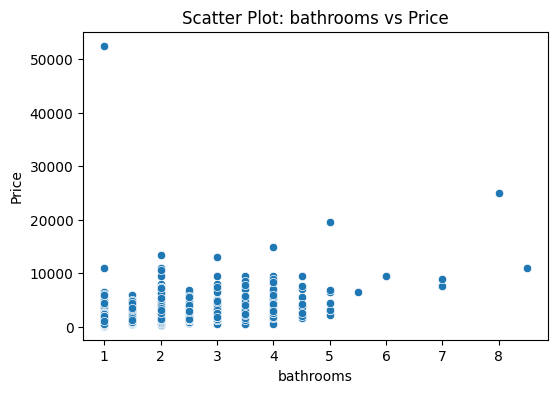

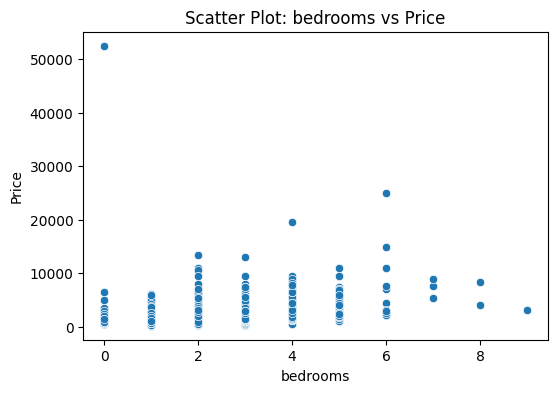

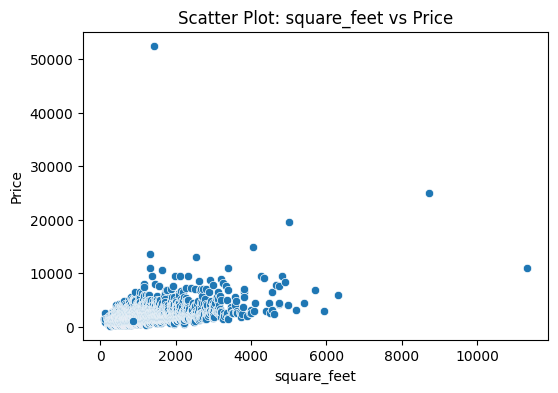

In [18]:
# pembuatan visualisasi scatter plot
scatter_viz = ['bathrooms','bedrooms','square_feet']

# loop untuk scatter plot antara scatter_viz vs price
for col in scatter_viz:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y='price', data=df)
    plt.title(f'Scatter Plot: {col} vs Price')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

>Secara umum, kolom dengan nilai numerik yaitu `bathrooms`,`bedrooms` dan `square_feet` terlihat memiliki korelasi positif terhadap `price` dengan beberapa pengecualian yang disebabkan oleh nilai yang diperkirakan merupakan outlier.

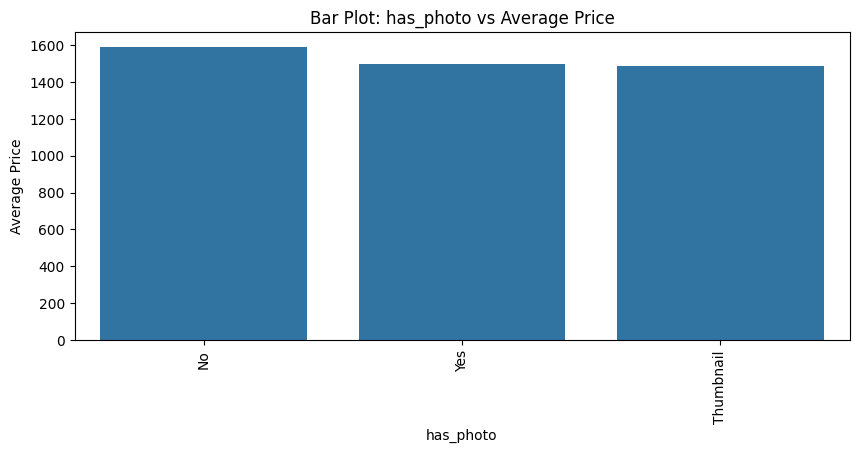

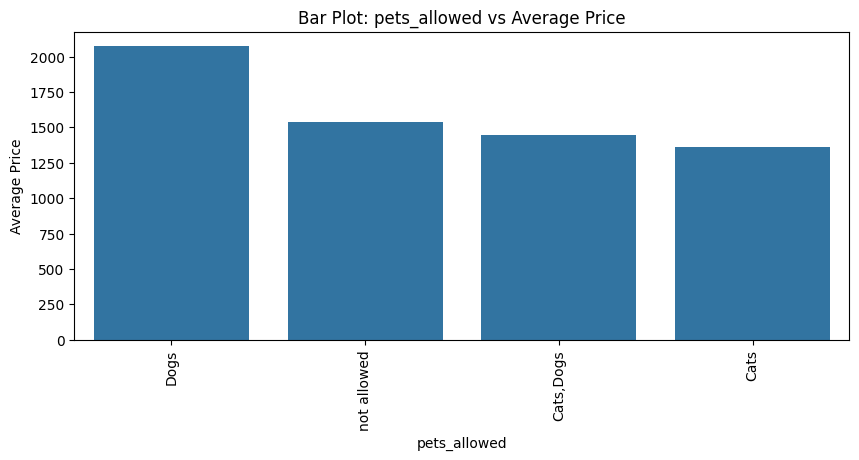

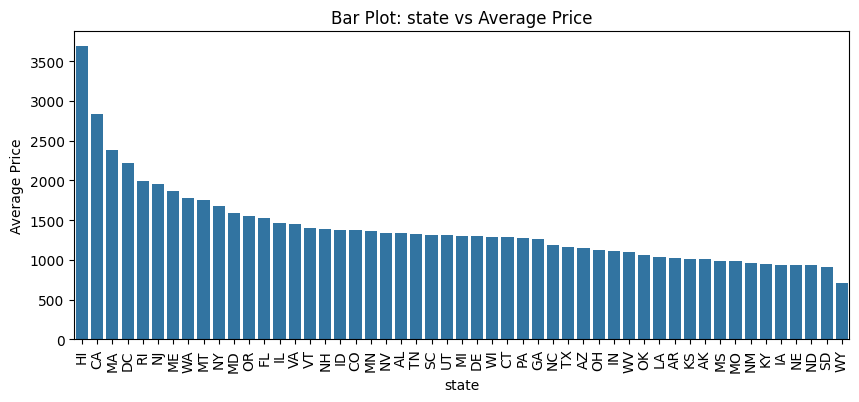

In [19]:
# pembuatan visualisasi bar plot
bar_viz = ['has_photo','pets_allowed','state']


# loop untuk scatter plot antara bar_viz vs avg price
for col in bar_viz:
    plt.figure(figsize=(10, 4))
    avg_price = df.groupby(col)['price'].mean().sort_values(ascending=False).reset_index()
    sns.barplot(x=col, y='price', data=avg_price)
    plt.title(f'Bar Plot: {col} vs Average Price')
    plt.xlabel(col)
    plt.ylabel('Average Price')
    plt.xticks(rotation=90)  # Rotasi label untuk keterbacaan
    # plt.tight_layout()
    plt.show()

Kolom `has_photo` tidak memiliki pengaruh terhadap terhadap average dari `price`.<br>
Kolom `pets_allowed` dengan value Dogs memiliki harga sewa tertinggi dibanding ketiga nilai lainnya.<br>
Kolom `state` menunjukkan nilai rata-rata harga sewa di masing-masing negara bagian yang diurutkan dari yang termahal. Negara bagian dengan harga sewa termahal adalah Hawaii sedangkan yang termurah adalah Wyoming.

# 5 FEATURE ENGINEERING (FE)

In [20]:
# tampilkan info dari data untuk diobservasi kembali
df.info()

# export data ke dalam file csv untuk keperluan deployment
df.to_csv('df.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     9879 non-null   float64
 1   bedrooms      9879 non-null   float64
 2   has_photo     9879 non-null   object 
 3   pets_allowed  9879 non-null   object 
 4   price         9879 non-null   int64  
 5   square_feet   9879 non-null   int64  
 6   state         9879 non-null   object 
 7   latitude      9879 non-null   float64
 8   longitude     9879 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 694.7+ KB


## Feature Selection

>Karena data terbaru tidak memiliki missing value, maka sebelum data masuk ke dalam feature engineering dapat dilakukan analisis korelasi untuk menentukan fitur mana saja yang relevan untuk dimasukkan ke dalam model.

Untuk melakukan seleksi fitur, kita perlu tahu korelasi masing-masing fitur dengan target.<br>
Dari 8 fitur yang tersedia, kita dapat membaginya berdasarkan jenis metode analisis korelasi dengan target yaitu:
- Fitur `bathrooms`, `bedrooms`, `square_feet`, `latitude` dan `longitude` memiliki nilai numerik, untuk analisis korelasi terhadap target yang merupakan data numerik juga maka akan menggunakan metode korelasi Pearson atau Spearman (tergantung pada jenis distribusi masing-masing fitur).
- Fitur `has_photo`, `pets_allowed` dan `state` memiliki nilai kategorik nominal, untuk analisis korelasi terhadap target yang merupakan data numerik maka akan menggunakan metode korelasi Anova.

### Fitur Numerik

>Hitung nilai skewness dari masing-masing fitur numerik untuk mengetahui normalitas distribusi.

In [21]:
# gunakan loops untuk menghitung nilai skewness dari fitur numerik
skew_level = ['bathrooms','bedrooms','square_feet','latitude','longitude']

for col in skew_level:
    skewness = df[col].skew()
    print(f"Nilai Skewness dari Fitur {col} adalah: {skewness}")

Nilai Skewness dari Fitur bathrooms adalah: 2.0562253547470375
Nilai Skewness dari Fitur bedrooms adalah: 1.1802935552352116
Nilai Skewness dari Fitur square_feet adalah: 3.5299246624596012
Nilai Skewness dari Fitur latitude adalah: 0.2880140006568442
Nilai Skewness dari Fitur longitude adalah: -0.6690826362050941


Berdasarkan nilai skewness, distribusi fitur numerik terbagi menjadi normal distribution (`latitude`) dan skewed distribution (`bathrooms`,`bedrooms`,`square_feet`,`longitude`). Untuk uji korelasi antara fitur bersifat skewed akan dilakukan menggunakan metode Spearman dan yang bersifat normal menggunakan metode Pearson.

Analisis korelasi  menggunakan nilai alfa = 0.05.<br>
Setelah melakukan analisis, jika p-value < 0.05, maka kita menolak hipotesis nol (H₀) dan menerima hipotesis alternatif (H₁).

>Hitung nilai korelasi fitur numerik yang bersifat skewed menggunakan metode analisis Spearman.

Hipotesis:<br>
Hipotesis Nol (H₀): Tidak ada hubungan monotonic yang signifikan antara fitur dan target.<br>
Hipotesis Alternatif (H₁): Ada hubungan monotonic yang signifikan antara fitur dan target.<br>

Berdasarkan Nilai Alfa:<br>
Jika p-value < α, kita menolak H₀ dan menerima H₁, yang berarti ada hubungan monotonic yang signifikan antara fitur dan target.<br>
Jika p-value ≥ α, kita gagal menolak H₀, yang berarti tidak ada hubungan monotonic yang signifikan.

In [22]:
# gunakan loops untuk menghitung korelasi dari fitur numerik skewed
skewed_features = ['bathrooms', 'bedrooms', 'square_feet', 'longitude']
target = 'price'

for col in skewed_features:
    korelasi, p_value = spearmanr(df[col], df[target])
    print(f"P-Value {col} terhadap {target}: {p_value:.3f}")


P-Value bathrooms terhadap price: 0.000
P-Value bedrooms terhadap price: 0.000
P-Value square_feet terhadap price: 0.000
P-Value longitude terhadap price: 0.000


Hasil dari analisis, seluruh fitur yang memiliki P-Value = 0 yang artinya **seluruh fitur skewed memiliki hubungan monotonik terhadap target** sehingga dapat dimasukkan ke dalam model.

>Hitung nilai korelasi fitur numerik yang bersifat normal menggunakan metode analisis Pearson.

Hipotesis:<br>
Hipotesis Nol (H₀): Ada hubungan linear yang signifikan antara fitur dan target.<br>
Hipotesis Alternatif (H₁): Tidak ada hubungan linear yang signifikan antara fitur dan target.<br>

Berdasarkan Nilai alfa:<br>
Jika p-value < α, kita menolak H₀ dan menerima H₁, yang berarti ada hubungan linear yang signifikan antara fitur dan target.<br>
Jika p-value ≥ α, kita gagal menolak H₀, yang berarti tidak ada hubungan linear yang signifikan.

In [23]:
# gunakan loops untuk menghitung korelasi dari fitur numerik normal
normal_features = ['latitude']
target = 'price'

for col in normal_features:
    korelasi, p_value = pearsonr(df[col], df[target])
    print(f"P-Value {col} terhadap {target}: {p_value:.3f}")

P-Value latitude terhadap price: 0.159


Hasil dari analisis **fitur `lattitude` memiliki korelasi linear terhadap target** maka fitur `latitude` akan dimasukkan ke dalam model.

### Fitur Kategorik

>Hitung nilai korelasi fitur kategorik nominal menggunakan metode analisis Anova.

Hipotesis:<br>
Hipotesis Nol (H₀): Tidak ada perbedaan yang signifikan dalam rata-rata antara fitur dan target.<br>
Hipotesis Alternatif (H₁): Ada perbedaan yang signifikan dalam rata-rata antara fitur dan target.<br>

Berdasarkan Nilai Alfa:<br>
Jika p-value < α, kita menolak H₀ dan menerima H₁, yang berarti ada perbedaan yang signifikan antara rata-rata fitur dan target.<br>
Jika p-value ≥ α, kita gagal menolak H₀, yang berarti tidak ada perbedaan signifikan antara rata-rata fitur dan target.

In [24]:
categorical_features = ['has_photo', 'pets_allowed', 'state']
target = 'price'

for col in categorical_features:
    # kelompokkan data berdasarkan kategori
    groups = [df[df[col] == value][target] for value in df[col].unique()]
    
    # hitung nilai ANOVA dan P-Value
    f_stat, p_value = f_oneway(*groups)
    
    # cukup tampilkan nilai P-Value
    print(f"P-Value {col} terhadap {target}: {p_value:.3f}")

P-Value has_photo terhadap price: 0.395
P-Value pets_allowed terhadap price: 0.000
P-Value state terhadap price: 0.000


Hasil dari analisis, **fitur `pets_allowed` dan `state` memiliki korelasi terhadap target**, sedangkan fitur `has_photo` tidak. Maka **fitur `has_photo` tidak akan dimasukkan ke dalam model**.

In [25]:
df.drop(['has_photo'], axis=1, inplace=True)

## Splitting Data

Sebelum data masuk ke dalam feature engineering selanjutnya, diperlukan splitting agar tidak terjadi kebocoran data terhadap algoritma.

In [26]:
# pisahkan dataframe menjadi feature (X) dan target (y)
X = df.drop(['price'], axis = 1)
y = df['price']

In [27]:
# bagi dataframe feature dan target masing-masing menjadi baris train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (7903, 7)
Test Size:  (1976, 7)


## Cek dan Handling Outlier

In [28]:
X_train.describe()

,bathrooms,bedrooms,square_feet,latitude,longitude
count,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000
mean,1.384791,1.749336,945.204859,37.681625,-94.554187
std,0.615372,0.944581,518.710399,5.515656,15.827785
min,1.000000,0.000000,116.000000,21.315500,-158.022100
25%,1.000000,1.000000,650.000000,33.688950,-101.301700
50%,1.000000,2.000000,809.000000,38.783500,-93.627600
75%,2.000000,2.000000,1100.000000,41.349800,-81.760200
max,8.000000,9.000000,8716.000000,61.594000,-70.191600


In [29]:
# buat variabel yang berisi fitur numerik saja
num_cols = list(X_train.select_dtypes(exclude='object').columns)
listItem= []

# cek kenormalan distribusi data masing-masing fitur numerik
for col in num_cols:
  listItem.append([col, round(X_train[col].skew(),1), np.where(
    (round(X_train[col].skew(),1) <= 0.5) & (round(X_train[col].skew(),1) >= -0.5),
    'normal',
    'skewed')])

skewness = pd.DataFrame(columns=['nama kolom', 'nilai skewness', 'distribution'], data= listItem)
skewness

,nama kolom,nilai skewness,distribution
0,bathrooms,1.9,skewed
1,bedrooms,1.2,skewed
2,square_feet,3.0,skewed
3,latitude,0.3,normal
4,longitude,-0.7,skewed


In [30]:
# cari nilai dari batas bawah, batas atas dan persentase dari outlier
column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['nama kolom'][row]
  # cek batas atas dan bawah
  if skewness['distribution'][row] == 'skewed':
    IQR = X_train[col].quantile(0.75) - X_train[col].quantile(0.25)
    lower_boundary = X_train[col].quantile(0.25) - (IQR * 3)
    upper_boundary = X_train[col].quantile(0.75) + (IQR * 3)
  else:
    lower_boundary = X_train[col].mean() - 3* X_train[col].std()
    upper_boundary = X_train[col].mean() + 3* X_train[col].std()
  # tambahkan ke list kosong
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(X_train[X_train[col] > upper_boundary]) / len(X_train) * 100) + (len(X_train[X_train[col] < lower_boundary]) / len(X_train) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    # bulatkan nilai
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,bathrooms,5.00,-2.00,0.05
1,bedrooms,5.00,-2.00,0.20
2,square_feet,2450.00,-700.00,2.06
3,latitude,54.23,21.13,0.47
4,longitude,-23.14,-159.93,0.00


Hasil perhitungan menunjukkan komposisi outlier terhadap masing-masing fitur tidak ada yang melewati 5%. Komposisi outlier yang relatif kecil akan menarik nilai central relatif secara dekat (tidak terlalu mempengaruhi distribusi data), jadi diputuskan untuk tidak dilakukan handling outlier.

## Feature Scaling

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7903 entries, 6392 to 7270
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     7903 non-null   float64
 1   bedrooms      7903 non-null   float64
 2   pets_allowed  7903 non-null   object 
 3   square_feet   7903 non-null   int64  
 4   state         7903 non-null   object 
 5   latitude      7903 non-null   float64
 6   longitude     7903 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 493.9+ KB


Sebelum masuk ke dalam algoritma, dilakukan Scaling dan Encoding untuk memudahkan model mempelajari pola dalam data.<br>
Scaling akan dilakukan terhadap fitur numerik (`bathrooms`, `bedrooms`, `square_feet`, `latitude`, `longitude`) dan encoding akan dilakukan terhadap fitur kategorik (`pets_allowed`, `state`).

In [32]:
X_train.describe()

,bathrooms,bedrooms,square_feet,latitude,longitude
count,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000
mean,1.384791,1.749336,945.204859,37.681625,-94.554187
std,0.615372,0.944581,518.710399,5.515656,15.827785
min,1.000000,0.000000,116.000000,21.315500,-158.022100
25%,1.000000,1.000000,650.000000,33.688950,-101.301700
50%,1.000000,2.000000,809.000000,38.783500,-93.627600
75%,2.000000,2.000000,1100.000000,41.349800,-81.760200
max,8.000000,9.000000,8716.000000,61.594000,-70.191600


In [33]:
skewness

,nama kolom,nilai skewness,distribution
0,bathrooms,1.9,skewed
1,bedrooms,1.2,skewed
2,square_feet,3.0,skewed
3,latitude,0.3,normal
4,longitude,-0.7,skewed


>Dari data terlihat value yang relatif sangat ekstrim terhadap distribusi, nilai skewness juga kebanyakan masuk ke kategori skewed-highly skewed, maka scaler yang akan digunakan adalah `Robust Scaler` karena menggunakan median dan IQR sehingga tidak akan terpengaruh oleh nilai ekstrim.

>Untuk fitur kategorik, nilai dari masing-masing fitur dapat dianggap tidak memiliki urutan (order) sehingga akan digunakan `One-Hot Encoder` dalam proses encoding.

In [34]:
# buat variabel berisi kolom yang akan di-scaling
robust_scaling_list = ['bathrooms', 'bedrooms', 'square_feet', 'longitude']

# buat variabel berisi kolom yang akan di-encoding
hot_encoding_list = ['pets_allowed', 'state']

# keduanya dibuat menjadi list agar bisa masuk dalam ColumnTransformer

In [35]:
# gunakan ColumnTransformer untuk menggabungkan proses scaling dan encoding
preprocessing_df = ColumnTransformer([('robust_scaled', RobustScaler(), robust_scaling_list),
                                   ('hot_encoded', OneHotEncoder(handle_unknown='ignore', sparse_output=False), hot_encoding_list)],
                                   remainder='drop')

In [36]:
# lakukan preprocessing dengan fit terhadap data train
X_train_preprocessed = preprocessing_df.fit_transform(X_train)

# lakukan preprocessing terhadap data test
X_test_preprocessed = preprocessing_df.transform(X_test)

In [37]:
# cek hasil preprocessing
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed,columns=preprocessing_df.get_feature_names_out())
X_train_preprocessed_df

,robust_scaled__bathrooms,robust_scaled__bedrooms,robust_scaled__square_feet,robust_scaled__longitude,hot_encoded__pets_allowed_Cats,"hot_encoded__pets_allowed_Cats,Dogs",hot_encoded__pets_allowed_Dogs,hot_encoded__pets_allowed_not allowed,hot_encoded__state_AK,hot_encoded__state_AL,...,hot_encoded__state_SD,hot_encoded__state_TN,hot_encoded__state_TX,hot_encoded__state_UT,hot_encoded__state_VA,hot_encoded__state_VT,hot_encoded__state_WA,hot_encoded__state_WI,hot_encoded__state_WV,hot_encoded__state_WY
0,0.0,-1.0,0.317778,0.216324,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.435556,-1.277793,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,0.175556,0.544723,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.640000,-1.453660,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,-1.0,-0.655556,1.001852,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,0.0,2.0,0.168889,0.304229,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7899,0.0,0.0,0.046667,0.989955,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7900,0.0,-1.0,0.091111,0.505724,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7901,0.0,0.0,-0.697778,-1.474314,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6 MODEL DEFINITION

>Model yang akan dibandingkan adalah KNN Regressor, SVM Regressor, DecisionTree Regressor, RandomForest Regressor dan XGBoost Regressor.<br>
- `KNN Regressor`: non parametrik, robust terhadap outlier karena hanya memperhatikan tetangga terdekat.
- `SVM Regressor`: mampu mempelajari data dengan dimensi tinggi karena belajar menggunakan nilai jarak, mampu membaca pola non-linear.
- `DecisionTree Regressor`: mampu membaca pola non-linear karena menggunakan metode splitting data berdasarkan nilai gini (kemurnian data), mampu mempelajari data campuran numerik dan kategorik dengan baik.
- `RandomForest Regressor`: merupakan bagging (ensamble learning) dari DecisionTree sehingga dapat menutupi kekurangannya berupa kecenderungan overfitting, mampu mempelajari pola pada data yang besar dan memiliki banyak fitur.
- `XGBoost Regressor`: baik dalam menangani overfitting, cepat dan efisien, cocok untuk data yang tidak terstruktur.

In [38]:
# buat instance model-model yang akan digunakan
knn = KNeighborsRegressor()
svm = SVR()
dt = DecisionTreeRegressor(random_state=69)
rf = RandomForestRegressor(random_state=70)
xgboost = xgb.XGBRegressor(random_state=69)

# 7 MODEL TRAINING

>Pelatihan model akan dilakukan menggunakan pipeline, karena akan dilakukan perbandingan antara 5 algoritma, maka akan dibuat 5 pipeline.

In [39]:
# buat pipeline
pipe_knn = Pipeline([('preprocessing', preprocessing_df),
                    ('knn', knn)])

pipe_svm = Pipeline([('preprocessing', preprocessing_df),
                    ('svm', svm)])

pipe_dt = Pipeline([('preprocessing', preprocessing_df),
                    ('dt', dt)])

pipe_rf = Pipeline([('preprocessing', preprocessing_df),
                    ('rf', rf)])

pipe_xgboost = Pipeline([('preprocessing', preprocessing_df),
                    ('xgboost', xgboost)])

Untuk menyederhanakan proses, dibuat for loops untuk melatih 5 model tersebut sekaligus crossvalidation di dalamnya. Skor evaluasi yang akan digunakan adalah Mean Absolute Error (MAE) dan model yang akan dipilih adalah model dengan MAE terkecil.

In [40]:
# buat list nama model dan algoritma model
algorithm = [
    ('pipe_knn', pipe_knn),
    ('pipe_svm', pipe_svm),
    ('pipe_dt', pipe_dt),
    ('pipe_rf', pipe_rf),
    ('pipe_xgboost', pipe_xgboost)
]

# loop untuk setiap model dalam daftar
for name, algo in algorithm:
    # lakukan cross-validation dengan scoring mae
    cv_score = -cross_val_score(estimator=algo,
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring='neg_mean_absolute_error')
    # cetak rata-rata mae untuk setiap model
    print(f'Rata-rata MAE CV {name} : {cv_score.mean()}')

Rata-rata MAE CV pipe_knn : 335.73029531061104
Rata-rata MAE CV pipe_svm : 472.4099131230465
Rata-rata MAE CV pipe_dt : 352.20874524282283
Rata-rata MAE CV pipe_rf : 279.58162855281995
Rata-rata MAE CV pipe_xgboost : 278.772329321347


Algoritma terbaik untuk melatih model adalah `XGBoost Regressor` karena memiliki rata-rata Mean Absolute Error terkecil yaitu 278.772.<br>
Selanjutnya akan dilakukan pelatihan model `XGBoost Regressor` dengan melakukan Hyper Parameter Tuning dengan harapan hasil MAE lebi772kecil lagi.

DISCLAIMER:<BR>
Cell di bawah jika dijalankan membutuhkan waktu 5-10 menit, jika ingin dikurangi maka silahkan n_iter dikurangi (namun hasilnya bisa berbeda)

In [41]:
# buat nilai dari hyperparameter yang akan di-tune
param_distributions = {
    'xgboost__n_estimators': [100, 200, 300, 500],  # Jumlah boosting rounds
    'xgboost__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],  # Tingkat pembelajaran
    'xgboost__max_depth': [3, 5, 6, 9, 10],  # Kedalaman maksimum pohon
    'xgboost__subsample': [0.5, 1.0, 1.5, 2.0, 3.0],  # Proporsi data yang digunakan
    'xgboost__colsample_bytree': [0.5, 1.0, 1.5, 2.0, 3.0],  # Proporsi fitur yang digunakan
    'xgboost__min_child_weight': [1, 3, 5, 7],  # Berat minimum untuk split
    'xgboost__reg_alpha': [0, 0.1, 1, 10],  # Regularisasi L1
    'xgboost__reg_lambda': [1, 10, 50, 100],  # Regularisasi L2
}

# lakukan hyperparameter tuning dengan RandomizedSearchCV
xgb_cv_tuned = RandomizedSearchCV(estimator=pipe_xgboost,
                                param_distributions=param_distributions,
                                n_iter=1000,
                                scoring='neg_mean_absolute_error',
                                cv=5,
                                verbose=2,
                                random_state=69,
                                n_jobs=-1)

# fit RandomizedSearchCV ke data train
xgb_cv_tuned.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('robust_scaled',
                                                                               RobustScaler(),
                                                                               ['bathrooms',
                                                                                'bedrooms',
                                                                                'square_feet',
                                                                                'longitude']),
                                                                              ('hot_encoded',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['pets_allowed',
                                                                                'state'])])),
                                             ('xgboost',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=N...
                                                                      1.5, 2.0,
                                                                      3.0],
                                        'xgboost__learning_rate': [0.01, 0.1,
                                                                   0.2, 0.3,
                                                                   0.4, 0.5],
                                        'xgboost__max_depth': [3, 5, 6, 9, 10],
                                        'xgboost__min_child_weight': [1, 3, 5,
                                                                      7],
                                        'xgboost__n_estimators': [100, 200, 300,
                                                                  500],
                                        'xgboost__reg_alpha': [0, 0.1, 1, 10],
                                        'xgboost__reg_lambda': [1, 10, 50, 100],
                                        'xgboost__subsample': [0.5, 1.0, 1.5,
                                                               2.0, 3.0]},
                   random_state=69, scoring='neg_mean_absolute_error',
                   verbose=2)

In [42]:
# tampilkan hasil terbaik
print("Best Parameters:", xgb_cv_tuned.best_params_)
print("Best MAE Score:", -xgb_cv_tuned.best_score_)

Best Parameters: {'xgboost__subsample': 1.0, 'xgboost__reg_lambda': 10, 'xgboost__reg_alpha': 1, 'xgboost__n_estimators': 100, 'xgboost__min_child_weight': 3, 'xgboost__max_depth': 9, 'xgboost__learning_rate': 0.2, 'xgboost__colsample_bytree': 0.5}
Best MAE Score: 278.64175165536193


In [43]:
# buat variabel berisi model dengan parameter terbaik
xgb_enhanced = xgb_cv_tuned.best_estimator_
xgb_enhanced

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('robust_scaled',
                                                  RobustScaler(),
                                                  ['bathrooms', 'bedrooms',
                                                   'square_feet',
                                                   'longitude']),
                                                 ('hot_encoded',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['pets_allowed', 'state'])])),
                ('xgboost',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsamp...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.2,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=69, ...))])

# 8 MODEL EVALUATION

In [44]:
# lakukan prediksi terhadap data test
y_pred = xgb_enhanced.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Tampilkan hasil
print("Hasil Evaluasi Model:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")


Hasil Evaluasi Model:
Mean Absolute Error (MAE): 308.8280
Mean Absolute Percentage Error (MAPE): 18.65%


Hasil pelatihan model terhadap data train: MAE 279.32.<br>
Hasil pelatihan model terhadap data test: MAE 308.26.<br>
Nilai MAE yang naik sekitar 30 menandakan model kurang konsisten dan memiliki kecenderungan overfit.
Namun jika dilihat secara relatif menggunakan nilai evaluasi Mean Absolute Percentage Error (MAPE) dengan nilai 18%, `performa model secara umum dapat dikatakan baik` karena nilai persentase tidak error yaitu 100%-18% = 82%.

# 9 MODEL SAVING

Simpan model ke dalam file pkl untuk dipakai di medium lain.

In [45]:
# buat file untuk menyimpan model
with open('xgb_enhanced.pkl', 'wb') as file_1:
    pickle.dump(xgb_enhanced, file_1)

# 10 MODEL INFERENCE

Untuk melakukan tes model dengan data baru, dilakukan pembuatan data berdasarkan dari sample data raw.

In [46]:
# buat data sample dari data raw
df_sample = raw.sample(n=5, random_state=69)
df_sample

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
5256,5663111837,housing/rent/home,"622 North Wayne Street, Apartment. A",Milledgeville STUCCO SIDING - DOWNTOWN WAYNE S...,"AC,Cable or Satellite,Dishwasher,Internet Acce...",1.0,2.0,USD,No,Thumbnail,...,$625,Monthly,828,622 North Wayne St,Milledgeville,GA,33.0769,-83.3032,ListedBuy,1576878211
7272,5668631101,housing/rent/apartment,Two BR 4400 Old Court Road,"This unit is located at 4400 Old Court Road, P...",NaN,2.0,2.0,USD,No,Thumbnail,...,"$1,285",Monthly,1066,4400 Old CT Rd,Pikesville,MD,39.3776,-76.7060,RentLingo,1577359736
1323,5664596231,housing/rent/apartment,One BR 5720 66th Street,"This unit is located at 5720 66th Street, Lubb...",NaN,1.0,1.0,USD,No,Thumbnail,...,$550,Monthly,542,5720 66th St,Lubbock,TX,33.5600,-101.8904,RentLingo,1577016962
4924,5664571420,housing/rent/apartment,Two BR 2114 Swift St.,"This unit is located at 2114 Swift St., Kansas...","Dishwasher,Internet Access,Patio/Deck,Refriger...",1.0,2.0,USD,No,Thumbnail,...,$950,Monthly,800,2114 Swift St,Kansas City,MO,39.0744,-94.5521,RentLingo,1577015087
5845,5627574530,housing/rent/apartment,2 BR in Ellensburg WA 98926,---- SCHEDULE A SHOWING OUR WEB ADDRESS AT: Li...,"Clubhouse,Dishwasher,Refrigerator,TV",2.0,2.0,USD,No,Thumbnail,...,"$1,165",Monthly,890,NaN,Ellensburg,WA,47.0012,-120.5424,ListedBuy,1574983159


In [47]:
# lakukan inference data
df_inference = xgb_enhanced.predict(df_sample)
pd.DataFrame(df_inference,columns=['Predicted Price'])

,Predicted Price
0,1034.353882
1,1747.560913
2,814.527405
3,771.152039
4,1173.715820


Model dapat berjalan dengan baik tanpa menimbulkan error dengan nilai prediksi yang dihasilkan telah ditampilkan pada dataframe di atas.

# 11 PENGAMBILAN KESIMPULAN

>Dalam proses pembuatan model ini, dapat ditarik beberapa kesimpulan yaitu:
- Dari 1 dataset perlu dilakukan pelatihan menggunakan beberapa algoritma untuk membandingkan langsung skor hasil pelatihannya.
- Dari data properti untuk disewakan, harga sewa dipengaruhi oleh fitur-fitur yang tersedia yaitu `bathrooms`, `bedrooms`, `pets_allowed`, `price`, `square_feet`, `state`, `latitude` dan `longitude`.
- Hasil pelatihan model menggunakan algoritma `XGBoost Regressor` memiliki skor `MAE 279.32` sehingga masuk kategori performa relatif baik.
- Hubungan antara harga sewa dengan fitur numerik lainnya cenderung memiliki korelasi positif.
- Harga sewa properti tertinggi berdasarkan fitur `pets_allowed` adalah yang mengizinkan anjing untuk masuk ke dalam properti dengan selisih nilai rata-rata sewanya yaitu USD 600.
- Harga sewa properti tertinggi berada di negara bagian Hawaii diikuti California, sedangkan yang terendah berada di negara bagian South Dakota dan Wyoming.